In [1]:
# here we're going to just try writing something from scratch

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# set up arrays
dx = 1000
x = np.arange(0, 100000, dx)
x_node = x + (dx/2)

Hstar = 0.5
etab = np.zeros(len(x)) # bedrock elevation, m
etab[:] = np.linspace(10, 0.1, len(x)) # need to start with slight bedrock slope
H = Hstar + np.zeros(len(x))
eta = etab + H

In [4]:
# set up parameters
K_ig = np.zeros(len(x))
K_ig[:24] = 1e-7
K_sed = np.zeros(len(x))
K_sed[24:] = 1e-6

beta_ig = np.zeros(len(x))
beta_ig[:24] = 4e-7
beta_sed = np.zeros(len(x))
beta_sed[24:] = 4e-6

# psi = np.zeros(len(x))
# psi[:14] = 4e-7
# psi[14:] = 4e-6
psi = 4e-7
gamma = 0.3

r = 10 # runoff rate
D = 0.015 # grain size
phi = 0.45 # porosity
baselevel_rate = 0.0001 # baselevel fall rate

In [5]:
kqs = 0.041
I = 0.01
kxb = 25
Pxb = 1./5.
kb = 8.3e-8

B_valley = kxb * (x_node**Pxb)
B_basin = (2./3.) * x_node

area = (1./3.) * x**2
# Q = r * x * B
Q = r * area

In [6]:
len(eta)

100

In [7]:
def model(x, dx, x_node,
          K_ig, K_sed, beta_ig, beta_sed,
          D, phi, Hstar, psi, gamma,
          kb, kqs, I, r, B_valley, B_basin, Q,
          etab, H, eta,
          baselevel_rate,
          num_steps = 1):
    
    q = Q/B_valley
    # dt = 0.2 * dx * dx / (kqs * q[-1]) # try changing to 10, 5, or 1 if this is unstable
    dt = 5
    
    run_duration = dt * num_steps
    cum_time = 0.0
    
    Qs = np.zeros(len(x))
    qs = np.zeros(len(x))
    Eb_p_ig = np.zeros(len(x))
    Eb_p_sed = np.zeros(len(x))
    Eb_a_ig = np.zeros(len(x))
    Eb_a_sed = np.zeros(len(x))
    Eb = np.zeros(len(x))
    Eh = np.zeros(len(x))
    E = np.zeros(len(x))
    ql = np.zeros(len(x))
    
    H[-1] = 0
    E[-1] = baselevel_rate
    q[0] = 0
    Qs[0] = 0
    ql[0] = 0
    
    while cum_time < run_duration:
        
        # drop baselevel
        eta[-1] -= baselevel_rate * dt
        
        # set boundary conditions
        etab[-1] = eta[-1]
        
        # calc slope
        S = -np.diff(eta)/dx
        
        # calc bed exposure
        alpha = np.exp(-H/Hstar)
        
        # calc Rh
#         width = (kb * Q[1:] * (S ** (7/6))) / (D**(3/2))
#         depth = (0.09801 * D) / S
#         Rh_efficiency = 1 - np.exp(-width/(2*depth))
        
        # calc sed transport
        Qs[1:] = kqs * I * Q[1:] * S**(7./6.) * (1 - alpha[:-1]) # * Rh_efficiency
        qs[1:] = Qs[1:] / B_valley[1:]
        
        # calc bedrock erosion
        Eb_p_ig[:-1] = K_ig[1:] * Q[1:] * S * alpha[:-1]
        Eb_p_sed[:-1] = K_sed[1:] * Q[1:] * S * alpha[:-1]
        Eb_a_ig[:-1] = beta_ig[1:] * Qs[1:] * alpha[:-1]
        Eb_a_sed[:-1] = beta_sed[1:] * Qs[1:] * alpha[:-1]
        Eb[:-1] = (Eb_p_ig[:-1] + Eb_p_sed[:-1] + Eb_a_ig[:-1] + Eb_a_sed[:-1]) / B_valley[:-1]
        
        # calc grain attrition
        atr = Qs * psi
        
        # calc equilibrium lateral supply
        ql[1:24] = ((baselevel_rate * gamma) / psi) * (1 - np.exp(-psi/(3 * x[1:24])))
        ql[24:] = 0
        
        # calc sediment erosion rate
        Eh[:-1] = 1/((1 - phi) * B_valley[:-1]) * (np.diff(Qs)/dx + atr[1:] - Eb_p_ig[:-1] - ql[1:])
        
        # calc total erosion rate
        E[:-1] = Eb[:-1] + Eh[:-1]
        
        # update topography
        etab[:-1] -= Eb[:-1] * dt
        H[:-1] -= Eh[:-1] * dt
        H[H<0] = 0
        eta[:-1] = etab[:-1] + H[:-1]
        
        # update elapsed time
        cum_time += dt
        
    print(cum_time)
        
    return (dt, S, q, alpha, Qs, qs, Eb_p_ig, Eb_p_sed, Eb_a_ig, Eb_a_sed, Eb, atr, ql, Eh, E, etab, H, eta)

In [8]:
#now write a test
num_steps = 5000000
test_run = [x, dx, x_node, 
            K_ig, K_sed, beta_ig, beta_sed, 
            D, phi, Hstar, psi, gamma,
            kb, kqs, I, r, B_valley, B_basin, Q,
            etab, H, eta,
            baselevel_rate,
            num_steps]

# and run it
(dt, S, q, alpha, Qs, qs, Eb_p_ig, Eb_p_sed, Eb_a_ig, Eb_a_sed, Eb, atr, ql, Eh, E, etab, H, eta) = model(*test_run)

25000000.0


In [9]:
dt

5

In [10]:
E

array([1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04])

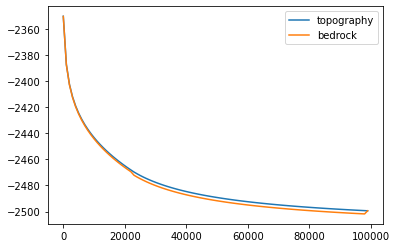

In [11]:
plt.plot(x, eta, label = "topography")
plt.plot(x, etab, label = "bedrock")
# plt.plot(x, H, label = "sediment")
plt.legend()

In [12]:
# just for kicks
kb = 8.3e-8
b = (kb * Q[1:] * (S ** (7/6))) / (D**(3/2))
print(b)

[ 3.21274424  4.5691602   5.94299744  7.3899716   8.9015778  10.46876542
 12.08451576 13.74343126 15.44126466 17.17458974 18.94058146 20.73686707
 22.56142251 24.41249847 26.2885661  28.18827637 30.11042894 32.05394801
 34.01786313 36.00129391 38.00343753 40.02355855 42.06098044 39.47646846
 39.45984618 39.44326799 39.4267311  39.41023296 39.39377132 39.37734414
 39.36094958 39.34458596 39.32825176 39.3119456  39.29566621 39.27941244
 39.2631832  39.24697752 39.2307945  39.21463328 39.1984931  39.18237323
 39.166273   39.15019179 39.134129   39.11808411 39.10205658 39.08604596
 39.07005178 39.05407362 39.0381111  39.02216383 39.00623146 38.99031366
 38.97441011 38.95852052 38.94264461 38.92678209 38.91093274 38.89509629
 38.87927253 38.86346123 38.84766218 38.8318752  38.81610008 38.80033666
 38.78458475 38.76884419 38.75311484 38.73739652 38.72168911 38.70599246
 38.69030644 38.67463093 38.65896579 38.64331093 38.62766621 38.61203153
 38.59640679 38.58079189 38.56518673 38.54959122 38

In [13]:
# ok really going out on a limb here...
depth = (0.09801 * D) / S
print(depth)

[ 0.03977399  0.09650323  0.15436658  0.20970866  0.26210174  0.31177545
  0.3590698   0.4043045   0.44775221  0.48963916  0.53015214  0.56944591
  0.60764961  0.64487192  0.68120504  0.71672784  0.75150834  0.78560563
  0.81907138  0.85195106  0.8842849   0.91610875  0.94745462  1.07609573
  1.15451574  1.23525407  1.31828786  1.40359542  1.49115614  1.58095042
  1.67295959  1.76716581  1.86355203  1.96210196  2.06279998  2.16563109
  2.27058092  2.37763562  2.48678191  2.59800697  2.71129845  2.82664445
  2.94403349  3.06345445  3.1848966   3.30834958  3.43380334  3.56124814
  3.69067458  3.8220735   3.95543605  4.09075363  4.22801788  4.3672207
  4.5083542   4.65141071  4.79638279  4.94326318  5.09204482  5.24272084
  5.39528453  5.54972938  5.70604903  5.86423728  6.02428807  6.18619552
  6.34995386  6.51555748  6.68300088  6.85227872  7.02338575  7.19631686
  7.37106706  7.54763146  7.72600528  7.90618385  8.0881626   8.27193707
  8.45750287  8.64485573  8.83399146  9.02490596  9.

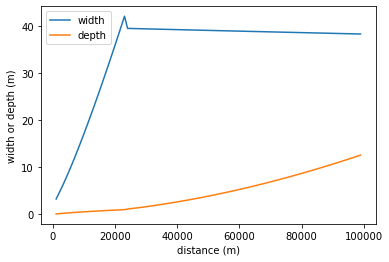

In [14]:
plt.plot(x[1:], b, label = 'width')
plt.plot(x[1:], depth, label = 'depth')
plt.ylabel('width or depth (m)')
plt.xlabel('distance (m)')
plt.legend()

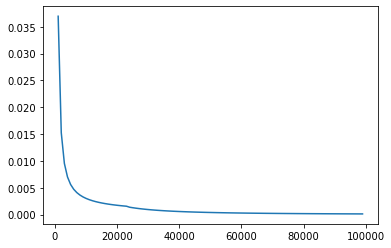

In [15]:
plt.plot(x[1:], S)

In [16]:
S

array([0.0369626 , 0.01523421, 0.00952376, 0.00701044, 0.00560908,
       0.00471541, 0.00409433, 0.00363624, 0.0032834 , 0.00300252,
       0.00277307, 0.00258172, 0.0024194 , 0.00227976, 0.00215816,
       0.0020512 , 0.00195627, 0.00187136, 0.0017949 , 0.00172563,
       0.00166253, 0.00160478, 0.00155168, 0.00136619, 0.00127339,
       0.00119016, 0.0011152 , 0.00104742, 0.00098591, 0.00092992,
       0.00087877, 0.00083193, 0.0007889 , 0.00074927, 0.0007127 ,
       0.00067886, 0.00064748, 0.00061832, 0.00059119, 0.00056588,
       0.00054223, 0.0005201 , 0.00049937, 0.0004799 , 0.0004616 ,
       0.00044438, 0.00042814, 0.00041282, 0.00039834, 0.00038465,
       0.00037168, 0.00035938, 0.00034772, 0.00033663, 0.00032609,
       0.00031607, 0.00030651, 0.0002974 , 0.00028872, 0.00028042,
       0.00027249, 0.0002649 , 0.00025765, 0.0002507 , 0.00024404,
       0.00023765, 0.00023152, 0.00022564, 0.00021998, 0.00021455,
       0.00020932, 0.00020429, 0.00019945, 0.00019478, 0.00019

In [17]:
ql

array([0.00000000e+00, 1.00000008e-08, 5.00000041e-09, 3.33333361e-09,
       2.50000021e-09, 2.00000017e-09, 1.66666680e-09, 1.42857393e-09,
       1.25000010e-09, 1.11111120e-09, 1.00000008e-09, 9.09089470e-10,
       8.33333402e-10, 7.69234676e-10, 7.14286963e-10, 6.66666722e-10,
       6.25000052e-10, 5.88237792e-10, 5.55555602e-10, 5.26312327e-10,
       5.00000041e-10, 4.76194084e-10, 4.54544735e-10, 4.34785541e-10,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [18]:
small_a_dist = 0.02 * x**(2)

In [19]:
small_a_dist

array([0.0000e+00, 2.0000e+04, 8.0000e+04, 1.8000e+05, 3.2000e+05,
       5.0000e+05, 7.2000e+05, 9.8000e+05, 1.2800e+06, 1.6200e+06,
       2.0000e+06, 2.4200e+06, 2.8800e+06, 3.3800e+06, 3.9200e+06,
       4.5000e+06, 5.1200e+06, 5.7800e+06, 6.4800e+06, 7.2200e+06,
       8.0000e+06, 8.8200e+06, 9.6800e+06, 1.0580e+07, 1.1520e+07,
       1.2500e+07, 1.3520e+07, 1.4580e+07, 1.5680e+07, 1.6820e+07,
       1.8000e+07, 1.9220e+07, 2.0480e+07, 2.1780e+07, 2.3120e+07,
       2.4500e+07, 2.5920e+07, 2.7380e+07, 2.8880e+07, 3.0420e+07,
       3.2000e+07, 3.3620e+07, 3.5280e+07, 3.6980e+07, 3.8720e+07,
       4.0500e+07, 4.2320e+07, 4.4180e+07, 4.6080e+07, 4.8020e+07,
       5.0000e+07, 5.2020e+07, 5.4080e+07, 5.6180e+07, 5.8320e+07,
       6.0500e+07, 6.2720e+07, 6.4980e+07, 6.7280e+07, 6.9620e+07,
       7.2000e+07, 7.4420e+07, 7.6880e+07, 7.9380e+07, 8.1920e+07,
       8.4500e+07, 8.7120e+07, 8.9780e+07, 9.2480e+07, 9.5220e+07,
       9.8000e+07, 1.0082e+08, 1.0368e+08, 1.0658e+08, 1.0952e

In [20]:
x

array([    0,  1000,  2000,  3000,  4000,  5000,  6000,  7000,  8000,
        9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000,
       18000, 19000, 20000, 21000, 22000, 23000, 24000, 25000, 26000,
       27000, 28000, 29000, 30000, 31000, 32000, 33000, 34000, 35000,
       36000, 37000, 38000, 39000, 40000, 41000, 42000, 43000, 44000,
       45000, 46000, 47000, 48000, 49000, 50000, 51000, 52000, 53000,
       54000, 55000, 56000, 57000, 58000, 59000, 60000, 61000, 62000,
       63000, 64000, 65000, 66000, 67000, 68000, 69000, 70000, 71000,
       72000, 73000, 74000, 75000, 76000, 77000, 78000, 79000, 80000,
       81000, 82000, 83000, 84000, 85000, 86000, 87000, 88000, 89000,
       90000, 91000, 92000, 93000, 94000, 95000, 96000, 97000, 98000,
       99000])

In [21]:
small_area = area[23]
small_a_array = np.linspace(0, small_area, len(x))
S_pred_array = ((baselevel_rate * gamma * small_a_array[1:])/(kqs * I * Q[1:]))**(6./7.)

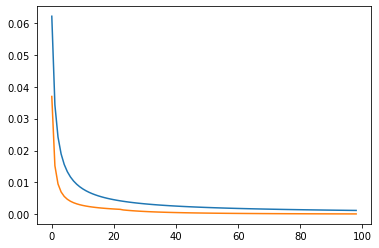

In [22]:
plt.plot(S_pred_array)
plt.plot(S)

In [23]:
S_pred_array

array([0.06212668, 0.03429671, 0.02422797, 0.01893332, 0.01563727,
       0.01337493, 0.01171948, 0.01045204, 0.00944835, 0.00863247,
       0.00795529, 0.00738356, 0.00689397, 0.00646968, 0.00609818,
       0.00576999, 0.00547782, 0.00521591, 0.00497971, 0.00476551,
       0.00457033, 0.00439167, 0.00422749, 0.00407605, 0.0039359 ,
       0.00380578, 0.00368464, 0.00357155, 0.00346573, 0.00336647,
       0.00327317, 0.00318529, 0.00310238, 0.003024  , 0.00294979,
       0.00287942, 0.00281258, 0.00274902, 0.00268849, 0.00263078,
       0.00257568, 0.00252303, 0.00247265, 0.0024244 , 0.00237815,
       0.00233377, 0.00229114, 0.00225016, 0.00221075, 0.00217279,
       0.00213622, 0.00210096, 0.00206694, 0.00203409, 0.00200234,
       0.00197166, 0.00194197, 0.00191324, 0.00188541, 0.00185844,
       0.0018323 , 0.00180693, 0.00178232, 0.00175843, 0.00173521,
       0.00171265, 0.00169072, 0.00166938, 0.00164862, 0.00162842,
       0.00160874, 0.00158957, 0.00157088, 0.00155267, 0.00153

In [24]:
difference = S_pred_array - S
print(difference)

[0.02516409 0.01906251 0.01470422 0.01192288 0.01002819 0.00865951
 0.00762515 0.0068158  0.00616495 0.00562996 0.00518222 0.00480184
 0.00447457 0.00418992 0.00394002 0.0037188  0.00352155 0.00334455
 0.00318481 0.00303989 0.0029078  0.0027869  0.00267581 0.00270987
 0.00266251 0.00261562 0.00256944 0.00252414 0.00247981 0.00243655
 0.00239439 0.00235337 0.00231348 0.00227473 0.00223709 0.00220056
 0.00216511 0.0021307  0.0020973  0.0020649  0.00203345 0.00200292
 0.00197328 0.0019445  0.00191655 0.00188939 0.001863   0.00183735
 0.0018124  0.00178814 0.00176454 0.00174158 0.00171922 0.00169745
 0.00167625 0.00165559 0.00163546 0.00161583 0.00159669 0.00157802
 0.00155981 0.00154203 0.00152467 0.00150773 0.00149117 0.001475
 0.0014592  0.00144375 0.00142864 0.00141387 0.00139942 0.00138528
 0.00137144 0.00135789 0.00134462 0.00133163 0.00131891 0.00130644
 0.00129422 0.00128225 0.0012705  0.00125899 0.0012477  0.00123662
 0.00122576 0.00121509 0.00120463 0.00119435 0.00118426 0.001174

In [25]:
area[13]

56333333.33333333

In [26]:
len(x)

100

In [27]:
abrasion_fraction = ((Eb_a_ig[:-1] + Eb_a_sed[:-1])/B_valley[1:])/Eb[:-1]
plucking_fraction = ((Eb_p_ig[:-1] + Eb_p_sed[:-1])/B_valley[1:])/Eb[:-1]

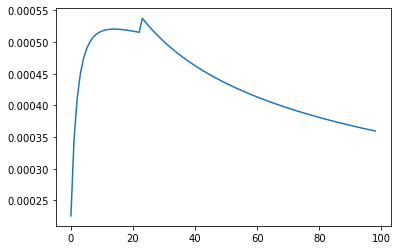

In [28]:
plt.plot(abrasion_fraction)
#plt.plot(plucking_fraction)